# Install Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install keras-tcn

     |████████████████████████████████| 1.1 MB 25.2 MB/s 


In [3]:
# Let`s import all packages that we may need:

import sys 
import time
import itertools
import datetime
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from itertools import product                    # some useful functions
#from tqdm import tqdm_notebook
from tqdm import tqdm

## for Deep-learing:
from tensorflow import keras
import tensorflow as tf
from keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
#from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout, Flatten, TimeDistributed
from tcn import TCN, tcn_full_summary, compiled_tcn, tcn
from tensorflow.keras.models import Sequential

from google.colab import files#

from keras import Input, Model
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D,  Dense, concatenate, Multiply
from keras.activations import relu


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Datasets


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Data/household_power_consumption.txt',
                 sep = ';', parse_dates = {'dt' : ['Date', 'Time']}, infer_datetime_format = True,
                 low_memory = False, na_values = ['nan','?'], index_col = 'dt')

In [5]:
df.head() 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [6]:
tf.random.set_seed(1234)

In [7]:
# Check for na values
df.isna().sum()
# Readings for 25979 observations missing

# Check the proportion of missing values

df.isna().sum()/df.shape[0]

Global_active_power      0.012518
Global_reactive_power    0.012518
Voltage                  0.012518
Global_intensity         0.012518
Sub_metering_1           0.012518
Sub_metering_2           0.012518
Sub_metering_3           0.012518
dtype: float64

In [8]:
def fill_missing(dat):
    window = 60 * 24
    for row in range(dat.shape[0]):
        for col in range(dat.shape[1]):
            if np.isnan(dat[row,col]):
                dat[row, col] = dat[row - window, col]

In [9]:
fill_missing(df.values)
df.isna().sum()
#df.head()
#df.info()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

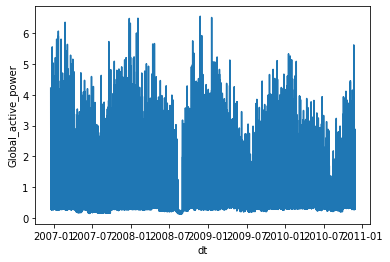

In [10]:
# As our focus is on getting a read on daily consumption it is a good idea
# to downsample the data to daily readings

df_resampled_hourly_avg = df.resample('H').mean()
df_resampled_hourly_avg.head()
df_resampled_hourly_avg.shape
# 34589,7
sns.lineplot(data=df_resampled_hourly_avg, y='Global_active_power',
             x=df_resampled_hourly_avg.index)

df_resample = df_resampled_hourly_avg.resample('D').mean()

In [11]:
## resampling of data over hour
#df_resample = df.resample('D').mean() 
print(df_resample) 
df_resample.shape

            Global_active_power  ...  Sub_metering_3
dt                               ...                
2006-12-16             3.120298  ...       12.692063
2006-12-17             2.354486  ...        9.264583
2006-12-18             1.530435  ...        9.734722
2006-12-19             1.157079  ...        4.303472
2006-12-20             1.545658  ...        9.765972
...                         ...  ...             ...
2010-11-22             1.417733  ...        7.038889
2010-11-23             1.095511  ...        5.285417
2010-11-24             1.247394  ...        8.488889
2010-11-25             0.993864  ...        3.522222
2010-11-26             1.167712  ...        7.567424

[1442 rows x 7 columns]


(1442, 7)

In [12]:
import calendar
calendar.day_name[df_resample.index.weekday[0]]

'Saturday'

In [13]:
df_resample_sliced = df_resample[2:]
df_resample_sliced.shape
calendar.day_name[df_resample_sliced.index.weekday[0]]

'Monday'

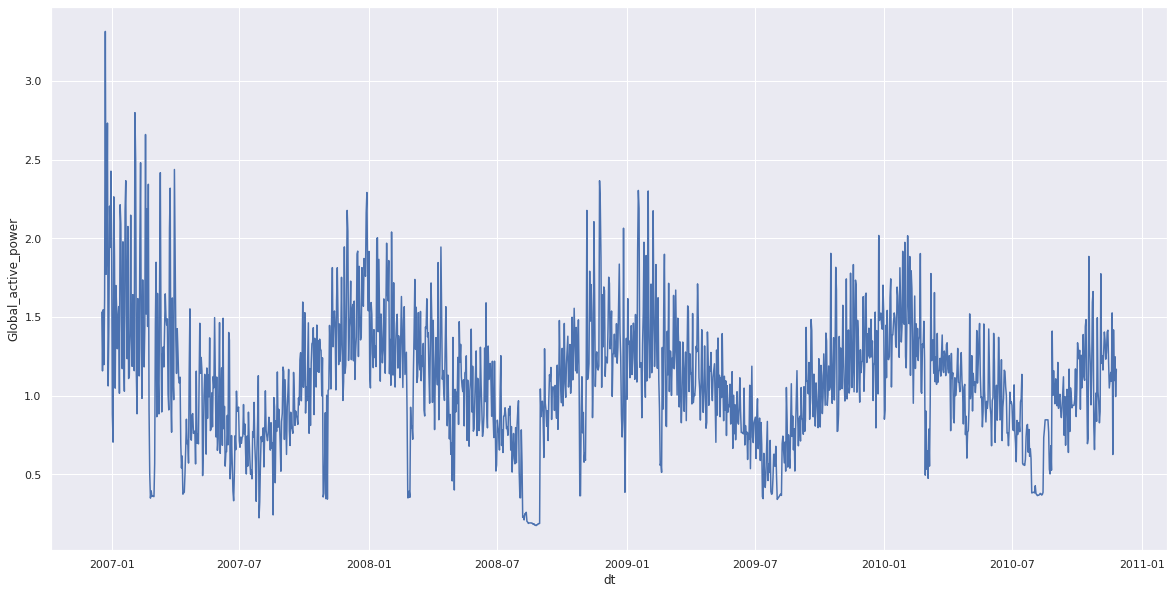

In [14]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=df_resample_sliced, y = 'Global_active_power', x= df_resample_sliced.index)

In [15]:
df_resample_sliced.shape

(1440, 7)

In [16]:

df_resample_day = df_resample_sliced


df_resample_day.head()

# Min and Max dates
df_resample_day.index.min()
# 2006-12-18
df_resample_day.index.max()
# 2010-11-26

df_resample_day_y = df_resample_day.loc[:,['Global_active_power']]

df_resample_day_y.head()
print(type(df_resample_day_y))

<class 'pandas.core.frame.DataFrame'>


In [17]:
df_resample_day_y = df_resample_day.loc[:,['Global_active_power']]

# Function Definitions

## General Function Definitions


In [18]:
def scale_data(dat, range =(0,1)):
  ## * Note: I scale all features in range of [0,1].

  ## If you would like to train based on the resampled data (over hour), then used below
  values = dat.values
  # normalize features
  scaler = MinMaxScaler(feature_range=range)
  scaled = scaler.fit_transform(values)

  #print(type(scaled))
  print("Shape of scaled dataset-",scaled.shape)
  #print(pd.DataFrame(scaled))

  return scaler, scaled

def forecast(model, historical_dat):
  dat = historical_dat[-1::]
  #print(dat)
  #print(dat.shape)
  yhat = model.predict(dat)
  return yhat[0]

def plot_actual_vs_pred(plot_dat, dat):
  ## time steps, every step is one day (you can easily convert the time step to the actual time index)
  ## 

  fig, ax = plt.subplots(figsize = (12,10))
  actual = plot_dat['test_actual'].reshape(plot_dat['test_actual'].shape[0]*plot_dat['test_actual'].shape[1])
  predicted = plot_dat['test_pred'].reshape(plot_dat['test_pred'].shape[0]*plot_dat['test_pred'].shape[1])
  aa=[x for x in range(len(dat))]
  plt.plot(aa, actual, marker='.', label="actual")
  plt.plot(aa, predicted, 'r', label="prediction")
  plt.ylabel('Sales', size=15)
  plt.xlabel('Time step', size=15)
  plt.legend(fontsize=15)
  plt.show()


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
def avg(nums):
    nums = list(nums)
    return round(sum(nums) / len(nums), 4)

def repeat_model(model, train, test, epochs, verbose, window=1, n_in=7, batchsize = None):
  start_time = time.time()
  model_dict = dict()
  train_X, train_y = train
  model_history = model.fit(train_X, train_y, epochs=epochs, batch_size=batchsize, validation_data=test, verbose=verbose, shuffle=False)
  history = train[0]
  predicted_vals = list()
  row_shape = [1]
  for i in range(1,len(train[0].shape)):
    row_shape.append(train[0].shape[i])
  row_shape = tuple(row_shape)
  for i in range(0, len(test[0]), window):
    history = np.append(history, test[0][i,:,:].reshape(row_shape), axis=0)
    yhat = forecast(model, history)
    predicted_vals.append(yhat)
  yhat = np.array(predicted_vals).reshape(len(predicted_vals),window)
  test_X = test[0][::window].copy()
  test_y = test[1][::window].copy()
  test_X = test_X.reshape((test_X.shape[0], n_in))
  inv_yhat = np.concatenate((test_X[:, :], yhat), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,-window:]
  test_y = test_y.reshape((len(test_y), window))
  inv_y = np.concatenate((test_X[:, :], test_y), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,-window:]
  rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
  print('Test RMSE: %.3f' % rmse)
  loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat)
  mae = tf.keras.losses.mean_absolute_error(inv_y, inv_yhat)
  model_dict['test_actual'] = inv_y
  model_dict['test_pred'] = inv_yhat
  model_dict['test_mape'] = np.mean(loss)
  model_dict['test_rmse'] = rmse
  model_dict['test_mae'] = np.mean(mae)
  model_dict['loss_from_model'] = model_history.history['loss'][-1]
  model_dict['val_loss_from_model'] = model_history.history['val_loss'][-1]
  print('MAPE: %.3f' % np.mean(loss))
  elapsed = time.time() - start_time
  model_dict['time_taken'] = elapsed
  return model_dict


def run_model(train, test, n_repeats, epochs, verbose=1, window=1, n_in = 7, learning_rate=0.01, loss= 'mae', batchsize=None, model_type="lstm", l2_regularizer=True):
  models = ["LSTM","CNN","CNN-LSTM","TCN","MACNN"]
  if model_type.upper() == "LSTM":
    model = build_model_lstm(train, window=window, learning_rate=learning_rate, loss = loss)
  elif model_type.upper() == "CNN":
    model = build_model_cnn(train, window=window, learning_rate=learning_rate, loss = loss)
  elif model_type.upper() == "CNN-LSTM":
    model = build_model_cnn_lstm(train, window=window, learning_rate=learning_rate, loss = loss)
  elif model_type.upper() == "TCN":
    model = build_model_tcn(train, window=window, learning_rate=learning_rate, loss = loss)
  elif model_type.upper() == "MACNN":
    if l2_regularizer:
      model = build_model_macnn(train, window=window, learning_rate=learning_rate, loss=loss)
    else:
      model = build_model_macnn_woregl(train, window=window, learning_rate=learning_rate, loss=loss)
  else:
    print("Please select a valid option for Model type")
    print("Available architectures available are-")
    print(models)
    return 0

  iter_history = dict()
  for i in range(n_repeats):
    print("Iteration-%d"%(i+1))
    iter_history['Iteration-'+str(i+1)] = repeat_model(model, train, test, epochs, verbose=verbose, window=window, n_in=n_in)
    print("Model-Loss = %.6f"%(iter_history['Iteration-'+str(i+1)]["loss_from_model"]))
    print("Model-Validation-Loss = %.6f"%(iter_history['Iteration-'+str(i+1)]["val_loss_from_model"]))

  
  print("Average MAPE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_mape"] for x in iter_history.values())))
  print("Average MAE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_mae"] for x in iter_history.values())))
  print("Average RMSE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_rmse"] for x in iter_history.values())))
  plot_actual_vs_pred(iter_history["Iteration-"+str(n_repeats)], test[0])
  iter_history["architecture"] = model_type.upper()
  iter_history["epochs"] = epochs
  iter_history["repeats"] = n_repeats
  iter_history["learning_rate"] = learning_rate
  iter_history["prediction_window"] = window
  iter_history["loss"] = loss.upper()
  #print(iter_history)
  return iter_history



## DL Model Definitions

In [19]:
def build_model_lstm(train_dat, learning_rate, loss, window=1):
  print("Compiling LSTM Model Architecture")
  model = Sequential()
  model.add(LSTM(64, input_shape=(train_dat[0].shape[1], train_dat[0].shape[2]),return_sequences=True))
  model.add(LSTM(16))
  #model.add(LSTM(16))
  model.add(Dropout(0.2))
  #model.add(LSTM(70))
  #model.add(Dropout(0.3))
  model.add(Dense(window))
  model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
  return model

In [22]:
def build_model_cnn(train_dat, learning_rate, loss, window=1):
  print("Compiling CNN Model Architecture")
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(window))
  model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
  return model
  


In [21]:
def build_model_cnn_lstm(train_dat, learning_rate, loss, window=1):
  print("Compiling CNN-LSTM Model Architecture")
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(50, activation='relu'))
  model.add(Dense(window))
  model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
  #model.summary()
  return model



In [20]:
def build_model_tcn(train_dat, learning_rate, loss, window=1):
  print("Compiling TCN Model Architecture")
  # if time_steps > tcn_layer.receptive_field, then we should not
# be able to solve this task.

  tcn_layer = TCN(input_shape=(train_dat[0].shape[1], 1),
                  nb_filters = 64,
                  kernel_size=2,
                  dilations = (1,2,4),
                  activation = 'relu',
                  use_skip_connections = True)

  # The receptive field tells you how far the model can see in terms of timesteps.
  print('Receptive field size =', tcn_layer.receptive_field)

  model = Sequential([
      tcn_layer,
      Dense(window)
  ])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=loss)
  model.summary()
  return model



In [23]:
def build_model_macnn_woregl(train_dat, learning_rate, loss, window=1):
  print("Compiling MACNN model Architecture(without regularization)")
  inputs = Input(shape=(train_dat[0].shape[1],1), name='series')
  conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same')(inputs)
  conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same')(inputs)
  conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same')(inputs)
  conv1 = concatenate([conv1_a, conv1_b, conv1_c])
  conv2 = Conv1D(filters=192,kernel_size=21,activation='relu', padding='same')(inputs)

  #conv1 = BatchNormalization()(conv1)
  msblock = relu(conv1)
  out = GlobalAveragePooling1D()(conv1)

  # Flatten the ouput
  #out = Flatten()(out)
  out = Dense(units=64)(out)
  out = Dense(units=192)(out)
  out = relu(out)

  attblock = Multiply()([out, msblock, conv2])
  attblock = Flatten()(attblock)
  attblock = Dense(units=window)(attblock)

  model = Model(inputs, attblock, name='MACNN')
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss=loss)
  model.summary()
  return model



In [24]:
def build_model_macnn(train_dat, learning_rate, loss, window=1):
  print("Compiling MACNN model Architecture(with regularization)")
  inputs = Input(shape=(train_dat[0].shape[1],1), name='series')
  conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same', kernel_regularizer=keras.regularizers.l2(l2=0.01))(inputs)
  conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same', kernel_regularizer=keras.regularizers.l2(l2=0.05))(inputs)
  conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same', kernel_regularizer=keras.regularizers.l2(l2=0.1))(inputs)
  conv1 = concatenate([conv1_a, conv1_b, conv1_c])
  conv2 = Conv1D(filters=192,kernel_size=21,activation='relu', padding='same')(inputs)

  #conv1 = BatchNormalization()(conv1)
  msblock = relu(conv1)
  out = GlobalAveragePooling1D()(conv1)

  # Flatten the ouput
  #out = Flatten()(out)
  out = Dense(units=64)(out)
  out = Dense(units=192)(out)
  out = relu(out)

  attblock = Multiply()([out, msblock, conv2])
  attblock = Flatten()(attblock)
  attblock = Dense(units=window)(attblock)

  model = Model(inputs, attblock, name='MACNN')
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss=loss)
  model.summary()
  return model



# Grid

In [25]:

repeats = [5]
epochs = [100]
learning_rate = [0.009]
loss_metric = ['mae']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid

,repeat,epoch,learning_rate,loss
0,5,100,0.009,mae


# Processing

Load External Factors Data and merge it to original data

In [29]:
df_resample_day_y.head()

,Global_active_power
dt,
2006-12-18,1.530435
2006-12-19,1.157079
2006-12-20,1.545658
2006-12-21,1.196728
2006-12-22,1.625929


In [31]:
mydateparser = lambda x:datetime.datetime.strptime(x,"%d-%m-%Y").strftime("%Y-%m-%d")
external_factors_dat = pd.read_csv("/content/drive/MyDrive/Data/paris_weather_data_daily.csv",
                                   index_col='date',parse_dates=['date'],
                                   date_parser=mydateparser)

In [32]:
external_factors_dat.head(12)

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
date,,,,,,,,,,,,,,,,,,,,
2006-12-18,8.0,3.0,0.0,7.80,1.5,31.5,4.0,2.0,5.5,2.0,29.5,51.0,91.0,5.00,1015.5,8.0,5.5,214.5,17.5,Paris
2006-12-19,7.0,2.0,0.0,6.00,1.5,31.0,2.5,0.0,4.5,0.0,33.0,50.5,88.5,5.80,1007.5,7.0,8.0,156.5,20.5,Paris
2006-12-20,4.5,0.0,0.0,4.25,1.0,31.0,0.5,-2.0,2.0,-2.0,23.0,55.0,89.5,2.90,1004.5,4.5,9.0,185.5,14.0,Paris
2006-12-21,5.5,1.0,0.0,6.05,1.0,31.5,1.5,0.0,2.5,0.0,16.5,63.5,92.0,0.45,1013.0,5.5,6.0,225.0,10.0,Paris
2006-12-22,6.5,1.5,0.0,5.15,1.0,31.5,2.5,-0.5,3.5,-0.5,32.0,73.0,92.0,5.35,1009.5,6.5,7.0,174.5,19.0,Paris
2006-12-23,7.0,2.5,0.0,5.20,1.5,31.0,3.0,1.5,5.0,1.5,31.0,77.5,87.5,3.55,1001.5,7.0,9.5,187.5,19.0,Paris
2006-12-24,5.5,2.5,0.0,4.30,1.0,31.0,2.5,1.0,4.0,1.0,16.5,68.5,91.0,0.60,1006.5,5.5,7.5,218.0,10.5,Paris
2006-12-25,5.5,1.0,0.0,4.30,1.0,34.0,1.5,-1.0,3.0,-1.0,24.0,68.0,91.0,0.55,1011.5,5.5,7.5,155.0,14.5,Paris
2006-12-26,4.0,-1.0,0.0,8.70,1.5,37.5,-0.5,-2.0,2.0,-2.0,17.5,51.5,86.0,0.15,1017.5,4.0,8.0,112.0,12.0,Paris


In [33]:

dat = pd.merge(df_resample_day_y,external_factors_dat[['maxtempC','mintempC']], left_index=True, right_index=True)
dat.head()

# sales_cat['date'] = pd.to_datetime(sales_cat['date'])

# sales_cat = sales_cat.set_index('date')

# sales_state = pd.merge(calender,sales_state,how = 'inner', left_on = 'd', right_on = 'days')

# sales_state['date'] = pd.to_datetime(sales_state['date'])

# sales_state = sales_state.set_index('date')

,Global_active_power,maxtempC,mintempC
dt,,,
2006-12-18,1.530435,8.0,3.0
2006-12-19,1.157079,7.0,2.0
2006-12-20,1.545658,4.5,0.0
2006-12-21,1.196728,5.5,1.0
2006-12-22,1.625929,6.5,1.5


# Models

## LSTM

### Window - 1

In [34]:
prediction_window = 1
# Scale dataset

# scaler, scaled = scale_data(dat, range=(-1,1))
# scaled_df = pd.DataFrame(scaled)
# scaled_df.set_index(dat.index, inplace=True)
# scaled_df.columns = dat.columns
# scaled_df[["Global_active_power"]]
#scaled_df_subset = 
# frame as supervised learning
print(dat)
reframed = series_to_supervised(dat[["Global_active_power"]], 7, n_out=prediction_window)
reframed = pd.merge(dat[["maxtempC","mintempC"]], reframed, left_index=True, right_index=True)
print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
print(reframed.head())

            Global_active_power  maxtempC  mintempC
dt                                                 
2006-12-18             1.530435       8.0       3.0
2006-12-19             1.157079       7.0       2.0
2006-12-20             1.545658       4.5       0.0
2006-12-21             1.196728       5.5       1.0
2006-12-22             1.625929       6.5       1.5
...                         ...       ...       ...
2010-11-22             1.417733       4.0       2.0
2010-11-23             1.095511       6.0       0.0
2010-11-24             1.247394       7.0       1.0
2010-11-25             0.993864       3.0      -1.0
2010-11-26             1.167712       4.0      -2.0

[1440 rows x 3 columns]
            maxtempC  mintempC  var1(t-7)  ...  var1(t-2)  var1(t-1)   var1(t)
dt                                         ...                                
2006-12-25       5.5       1.0   1.530435  ...   3.314851   1.770842  1.904944
2006-12-26       4.0      -1.0   1.157079  ...   1.770842   1.

In [35]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


178

In [36]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1246
182
(1246, 1, 9) (1246, 1) (182, 1, 9) (182, 1)


Train dataset shape- (1246, 1, 9)
Test dataset shape- (182, 1, 9)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-100
Learning rate used in model-0.00900
Error metric used in model-mae
Compiling LSTM Model Architecture
Iteration-1
Test RMSE: 0.224
MAPE: 18.350
Model-Loss = 0.153619
Model-Validation-Loss = 0.126469
Iteration-2
Test RMSE: 0.219
MAPE: 17.010
Model-Loss = 0.135986
Model-Validation-Loss = 0.121895
Iteration-3
Test RMSE: 0.220
MAPE: 17.813
Model-Loss = 0.136342
Model-Validation-Loss = 0.123183
Iteration-4
Test RMSE: 0.216
MAPE: 18.264
Model-Loss = 0.127914
Model-Validation-Loss = 0.120549
Iteration-5
Test RMSE: 0.238
MAPE: 25.057
Model-Loss = 0.118049
Model-Validation-Loss = 0.145421
Average MAPE for test data over 5 repetitions is 19.2988
Average MAE for test data over 5 repetitions is 0.1673
Average RMSE for test data over 5 repetitions is 0.2235


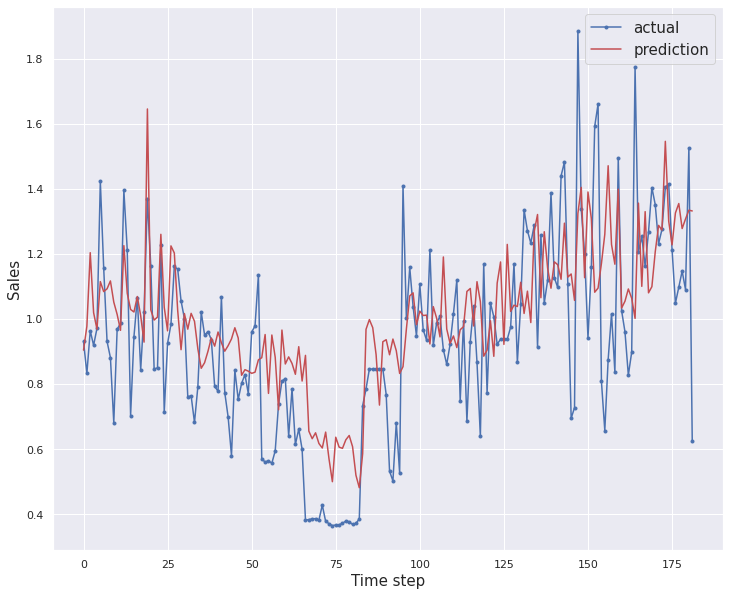

Time Taken for current trial is: 00:02:12
****************************************************************************************************


In [38]:
train = (train_X, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (test_X, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="LSTM", n_in=9)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

### Window-7

In [40]:
prediction_window = 7
# Scale dataset

# scaler, scaled = scale_data(dat, range=(-1,1))
# scaled_df = pd.DataFrame(scaled)
# scaled_df.set_index(dat.index, inplace=True)
# scaled_df.columns = dat.columns
# scaled_df[["Global_active_power"]]
#scaled_df_subset = 
# frame as supervised learning
print(dat)
reframed = series_to_supervised(dat[["Global_active_power"]], 7, n_out=prediction_window)
reframed = pd.merge(dat[["maxtempC","mintempC"]], reframed, left_index=True, right_index=True)
print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
print(reframed.head())

            Global_active_power  maxtempC  mintempC
dt                                                 
2006-12-18             1.530435       8.0       3.0
2006-12-19             1.157079       7.0       2.0
2006-12-20             1.545658       4.5       0.0
2006-12-21             1.196728       5.5       1.0
2006-12-22             1.625929       6.5       1.5
...                         ...       ...       ...
2010-11-22             1.417733       4.0       2.0
2010-11-23             1.095511       6.0       0.0
2010-11-24             1.247394       7.0       1.0
2010-11-25             0.993864       3.0      -1.0
2010-11-26             1.167712       4.0      -2.0

[1440 rows x 3 columns]
            maxtempC  mintempC  var1(t-7)  ...  var1(t+4)  var1(t+5)  var1(t+6)
dt                                         ...                                 
2006-12-25       5.5       1.0   1.530435  ...   2.204439   1.941742   2.426525
2006-12-26       4.0      -1.0   1.157079  ...   1.941742  

In [41]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


177

In [44]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1239
182
(1239, 1, 9) (1239, 7) (182, 1, 9) (182, 7)


Train dataset shape- (1239, 1, 9)
Test dataset shape- (182, 1, 9)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-100
Learning rate used in model-0.00900
Error metric used in model-mae
Compiling LSTM Model Architecture
Iteration-1
Test RMSE: 0.243
MAPE: 24.981
Model-Loss = 0.175400
Model-Validation-Loss = 0.146933
Iteration-2
Test RMSE: 0.232
MAPE: 23.032
Model-Loss = 0.163105
Model-Validation-Loss = 0.141482
Iteration-3
Test RMSE: 0.229
MAPE: 22.591
Model-Loss = 0.157459
Model-Validation-Loss = 0.142663
Iteration-4
Test RMSE: 0.239
MAPE: 22.928
Model-Loss = 0.150502
Model-Validation-Loss = 0.144463
Iteration-5
Test RMSE: 0.243
MAPE: 23.389
Model-Loss = 0.142496
Model-Validation-Loss = 0.147380
Average MAPE for test data over 5 repetitions is 23.3845
Average MAE for test data over 5 repetitions is 0.1906
Average RMSE for test data over 5 repetitions is 0.2372


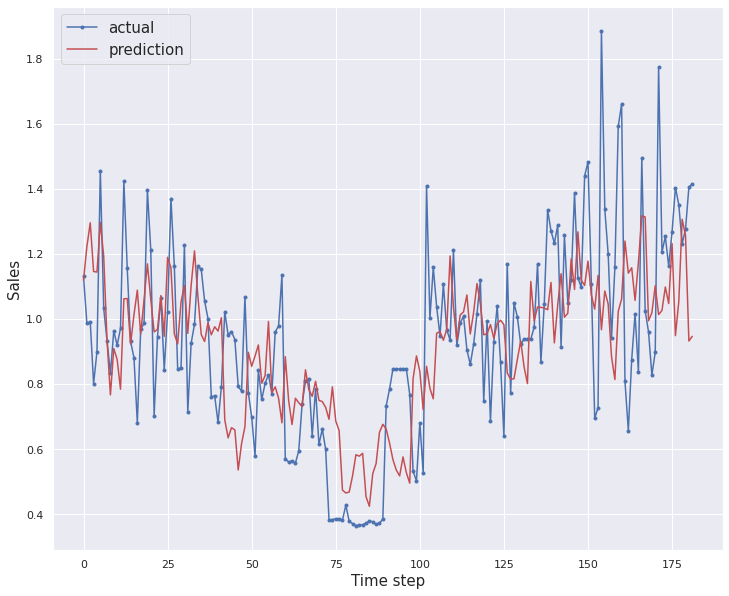

Time Taken for current trial is: 00:01:35
****************************************************************************************************


In [45]:
train = (train_X, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (test_X, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="LSTM", n_in=9)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

## CNN

### Window -1

In [47]:
prediction_window = 1
reframed = series_to_supervised(dat[["Global_active_power"]], 7, n_out=prediction_window)
reframed = pd.merge(dat[["maxtempC","mintempC"]], reframed, left_index=True, right_index=True)
print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
print(reframed.head())

            maxtempC  mintempC  var1(t-7)  ...  var1(t-2)  var1(t-1)   var1(t)
dt                                         ...                                
2006-12-25       5.5       1.0   1.530435  ...   3.314851   1.770842  1.904944
2006-12-26       4.0      -1.0   1.157079  ...   1.770842   1.904944  2.732021
2006-12-27       4.0      -2.0   1.545658  ...   1.904944   2.732021  1.061639
2006-12-28       5.5       0.0   1.196728  ...   2.732021   1.061639  1.439332
2006-12-29       4.0       0.0   1.625929  ...   1.061639   1.439332  2.204439
...              ...       ...        ...  ...        ...        ...       ...
2010-11-22       4.0       2.0   1.213460  ...   1.525699   0.625632  1.417733
2010-11-23       6.0       0.0   1.048436  ...   0.625632   1.417733  1.095511
2010-11-24       7.0       1.0   1.098633  ...   1.417733   1.095511  1.247394
2010-11-25       3.0      -1.0   1.147328  ...   1.095511   1.247394  0.993864
2010-11-26       4.0      -2.0   1.090556  ...   1.2

In [48]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


178

In [49]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1246
182
(1246, 9) (1246, 1) (182, 9) (182, 1)


In [50]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1246, 9, 1)
Validation set shape (182, 9, 1)


**Grid**

In [53]:

repeats = [5]
epochs = [100]
learning_rate = [0.006]
loss_metric = ['mse']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid

,repeat,epoch,learning_rate,loss
0,5,100,0.006,mse


Train dataset shape- (1246, 9, 1)
Test dataset shape- (182, 9, 1)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-100
Learning rate used in model-0.00600
Error metric used in model-mse
Compiling CNN Model Architecture
Iteration-1
Test RMSE: 0.241
MAPE: 23.441
Model-Loss = 0.041317
Model-Validation-Loss = 0.033635
Iteration-2
Test RMSE: 0.254
MAPE: 23.228
Model-Loss = 0.032501
Model-Validation-Loss = 0.037601
Iteration-3
Test RMSE: 0.263
MAPE: 25.204
Model-Loss = 0.028785
Model-Validation-Loss = 0.040162
Iteration-4
Test RMSE: 0.292
MAPE: 29.468
Model-Loss = 0.028646
Model-Validation-Loss = 0.049409
Iteration-5
Test RMSE: 0.284
MAPE: 26.051
Model-Loss = 0.024228
Model-Validation-Loss = 0.046729
Average MAPE for test data over 5 repetitions is 25.4785
Average MAE for test data over 5 repetitions is 0.2095
Average RMSE for test data over 5 repetitions is 0.2667


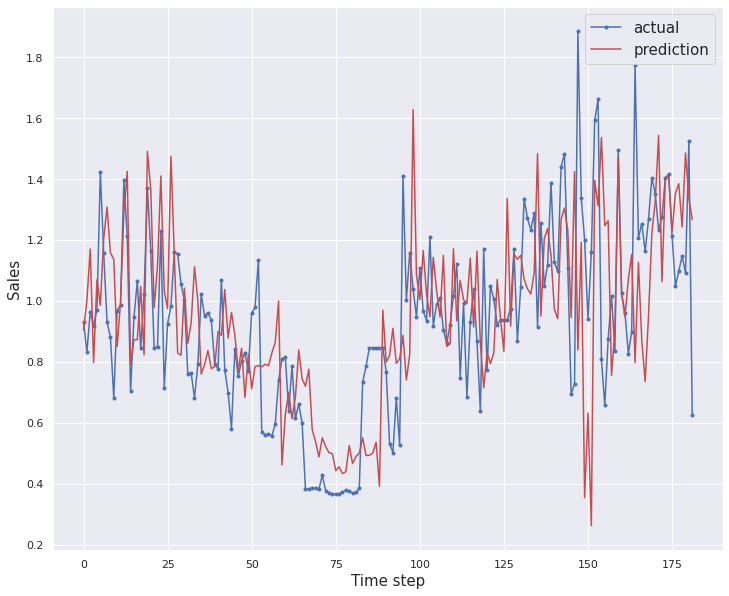

Time Taken for current trial is: 00:01:28
****************************************************************************************************


In [54]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="CNN", n_in=9)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

### Window -7

In [60]:
prediction_window = 7
reframed = series_to_supervised(dat[["Global_active_power"]], 7, n_out=prediction_window)
reframed = pd.merge(dat[["maxtempC","mintempC"]], reframed, left_index=True, right_index=True)
print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
#print(reframed.head())

            maxtempC  mintempC  var1(t-7)  ...  var1(t+4)  var1(t+5)  var1(t+6)
dt                                         ...                                 
2006-12-25       5.5       1.0   1.530435  ...   2.204439   1.941742   2.426525
2006-12-26       4.0      -1.0   1.157079  ...   1.941742   2.426525   1.909031
2006-12-27       4.0      -2.0   1.545658  ...   2.426525   1.909031   0.881414
2006-12-28       5.5       0.0   1.196728  ...   1.909031   0.881414   0.704204
2006-12-29       4.0       0.0   1.625929  ...   0.881414   0.704204   2.263481
...              ...       ...        ...  ...        ...        ...        ...
2010-11-16      11.0       4.0   1.404235  ...   1.525699   0.625632   1.417733
2010-11-17       6.0       1.0   1.351760  ...   0.625632   1.417733   1.095511
2010-11-18       7.0       3.0   1.231661  ...   1.417733   1.095511   1.247394
2010-11-19       8.0       6.0   1.275571  ...   1.095511   1.247394   0.993864
2010-11-20       9.0       4.0   1.40498

In [61]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


177

In [62]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1239
182
(1239, 9) (1239, 7) (182, 9) (182, 7)


In [63]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1239, 9, 1)
Validation set shape (182, 9, 1)


Train dataset shape- (1239, 9, 1)
Test dataset shape- (182, 9, 1)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-100
Learning rate used in model-0.00600
Error metric used in model-mse
Compiling CNN Model Architecture
Iteration-1
Test RMSE: 0.237
MAPE: 23.422
Model-Loss = 0.055846
Model-Validation-Loss = 0.035500
Iteration-2
Test RMSE: 0.268
MAPE: 30.368
Model-Loss = 0.051989
Model-Validation-Loss = 0.049169
Iteration-3
Test RMSE: 0.259
MAPE: 27.972
Model-Loss = 0.054168
Model-Validation-Loss = 0.043320
Iteration-4
Test RMSE: 0.253
MAPE: 23.718
Model-Loss = 0.049337
Model-Validation-Loss = 0.040607
Iteration-5
Test RMSE: 0.250
MAPE: 23.482
Model-Loss = 0.047979
Model-Validation-Loss = 0.040002
Average MAPE for test data over 5 repetitions is 25.7925
Average MAE for test data over 5 repetitions is 0.2021
Average RMSE for test data over 5 repetitions is 0.2532


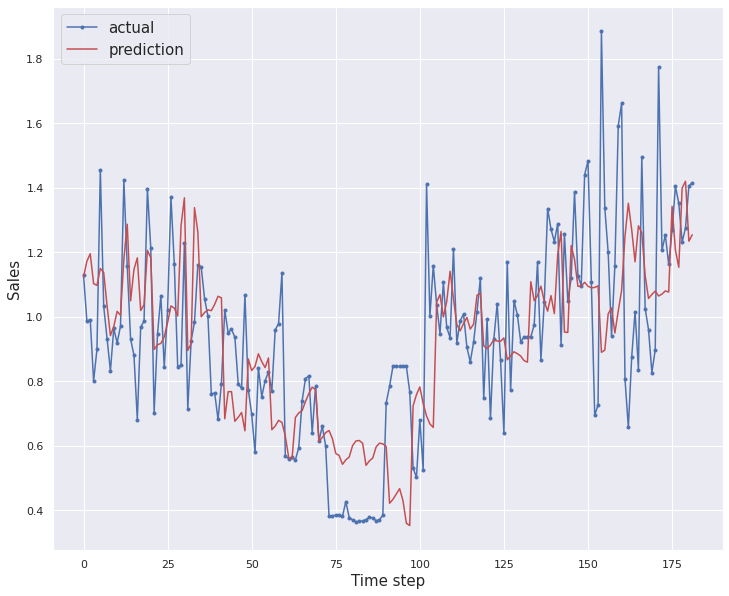

Time Taken for current trial is: 00:00:54
****************************************************************************************************


In [64]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="CNN", n_in=9)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

## CNN + LSTM

### Window-1

In [65]:
prediction_window = 1#
reframed = series_to_supervised(dat[["Global_active_power"]], 7, n_out=prediction_window)
reframed = pd.merge(dat[["maxtempC","mintempC"]], reframed, left_index=True, right_index=True)
#print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
#print(reframed.head())

Shape of scaled dataset- (1433, 10)
Shape of reframed dataset- (1433, 10)


In [66]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


178

In [67]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1246
182
(1246, 9) (1246, 1) (182, 9) (182, 1)


In [68]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1246, 9, 1)
Validation set shape (182, 9, 1)


In [69]:
subsequences = 1
timesteps = train_X.shape[1]//subsequences
print(timesteps)
X_train_series_sub = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

9
Train set shape (1246, 1, 9, 1)
Validation set shape (182, 1, 9, 1)


**Grid**

In [70]:

repeats = [5]
epochs = [100]
learning_rate = [0.008]
loss_metric = ['mae']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid

,repeat,epoch,learning_rate,loss
0,5,100,0.008,mae


Train dataset shape- (1246, 1, 9, 1)
Test dataset shape- (182, 1, 9, 1)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-100
Learning rate used in model-0.00800
Error metric used in model-mae
Compiling CNN-LSTM Model Architecture
Iteration-1
Test RMSE: 0.257
MAPE: 27.017
Model-Loss = 0.146231
Model-Validation-Loss = 0.153244
Iteration-2
Test RMSE: 0.230
MAPE: 20.912
Model-Loss = 0.128363
Model-Validation-Loss = 0.134963
Iteration-3
Test RMSE: 0.247
MAPE: 25.793
Model-Loss = 0.117399
Model-Validation-Loss = 0.150469
Iteration-4
Test RMSE: 0.254
MAPE: 20.915
Model-Loss = 0.105294
Model-Validation-Loss = 0.144585
Iteration-5
Test RMSE: 0.261
MAPE: 22.809
Model-Loss = 0.101300
Model-Validation-Loss = 0.152800
Average MAPE for test data over 5 repetitions is 23.4893
Average MAE for test data over 5 repetitions is 0.1932
Average RMSE for test data over 5 repetitions is 0.2499


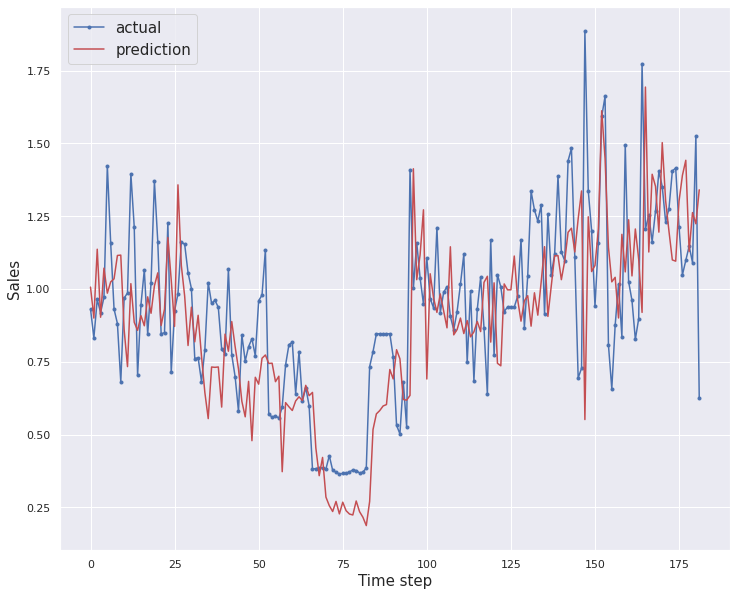

Time Taken for current trial is: 00:02:13
****************************************************************************************************


In [71]:
train = (X_train_series_sub, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series_sub, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="CNN-LSTM", n_in=9)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

### Window-7

In [72]:
prediction_window = 7#
reframed = series_to_supervised(dat[["Global_active_power"]], 7, n_out=prediction_window)
reframed = pd.merge(dat[["maxtempC","mintempC"]], reframed, left_index=True, right_index=True)
#print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
#print(reframed.head())

Shape of scaled dataset- (1427, 16)
Shape of reframed dataset- (1427, 16)


In [73]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


177

In [74]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1239
182
(1239, 9) (1239, 7) (182, 9) (182, 7)


In [75]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1239, 9, 1)
Validation set shape (182, 9, 1)


In [76]:
subsequences = 1
timesteps = train_X.shape[1]//subsequences
print(timesteps)
X_train_series_sub = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

9
Train set shape (1239, 1, 9, 1)
Validation set shape (182, 1, 9, 1)


Train dataset shape- (1239, 1, 9, 1)
Test dataset shape- (182, 1, 9, 1)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-100
Learning rate used in model-0.00800
Error metric used in model-mae
Compiling CNN-LSTM Model Architecture
Iteration-1
Test RMSE: 0.276
MAPE: 30.239
Model-Loss = 0.170573
Model-Validation-Loss = 0.162992
Iteration-2
Test RMSE: 0.266
MAPE: 28.106
Model-Loss = 0.161317
Model-Validation-Loss = 0.155569
Iteration-3
Test RMSE: 0.275
MAPE: 28.113
Model-Loss = 0.153776
Model-Validation-Loss = 0.153055
Iteration-4
Test RMSE: 0.280
MAPE: 23.754
Model-Loss = 0.149693
Model-Validation-Loss = 0.160234
Iteration-5
Test RMSE: 0.254
MAPE: 22.858
Model-Loss = 0.144988
Model-Validation-Loss = 0.150621
Average MAPE for test data over 5 repetitions is 26.6141
Average MAE for test data over 5 repetitions is 0.2165
Average RMSE for test data over 5 repetitions is 0.2702


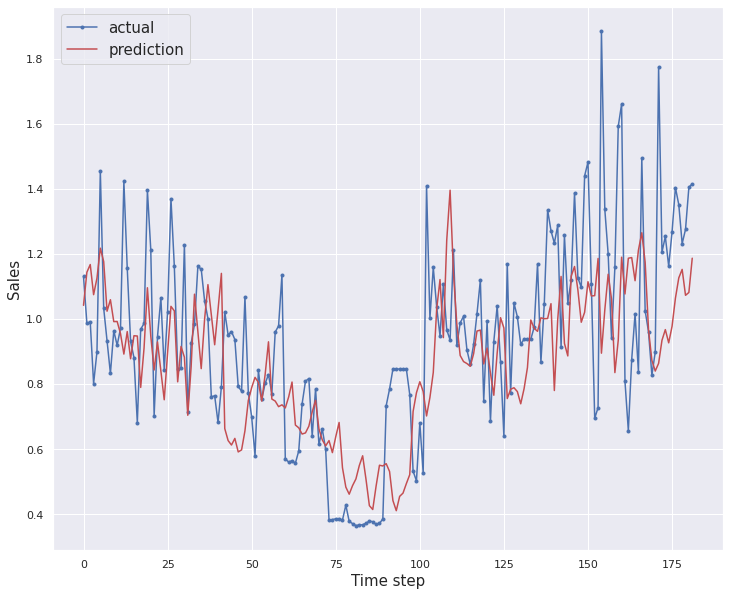

Time Taken for current trial is: 00:01:35
****************************************************************************************************


In [77]:
train = (X_train_series_sub, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series_sub, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="CNN-LSTM", n_in=9)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

## TCN

### Window-1

In [78]:
prediction_window = 1#
reframed = series_to_supervised(dat[["Global_active_power"]], 7, n_out=prediction_window)
reframed = pd.merge(dat[["maxtempC","mintempC"]], reframed, left_index=True, right_index=True)
#print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
#print(reframed.head())

Shape of scaled dataset- (1433, 10)
Shape of reframed dataset- (1433, 10)


In [79]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


178

In [80]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1246
182
(1246, 9) (1246, 1) (182, 9) (182, 1)


In [81]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1246, 9, 1)
Validation set shape (182, 9, 1)


**Grid**

In [82]:

repeats = [5]
epochs = [100]
learning_rate = [0.004]
loss_metric = ['mae']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid

,repeat,epoch,learning_rate,loss
0,5,100,0.004,mae


Train dataset shape- (1246, 9, 1)
Test dataset shape- (182, 9, 1)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-100
Learning rate used in model-0.00400
Error metric used in model-mae
Compiling TCN Model Architecture
Receptive field size = 15
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 64)                41600     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 41,665
Trainable params: 41,665
Non-trainable params: 0
_________________________________________________________________
Iteration-1
Test RMSE: 0.230
MAPE: 19.251
Model-Loss = 0.130642
Model-Validation-Loss = 0.132530
Iteration-2
Test RMSE: 0.243
MAPE: 22.069
Model-Loss = 0.076735
Model-Validation-Loss = 0.141616
Iteration-3
Test RMSE: 0.238
MAPE: 20.354
Mo

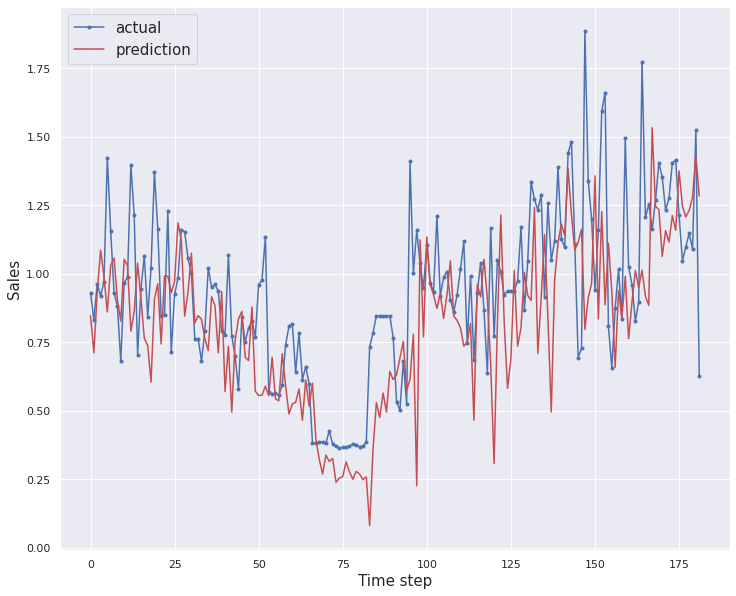

Time Taken for current trial is: 00:07:16
****************************************************************************************************


In [83]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="TCN", n_in=9)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

### Window-7

In [84]:
prediction_window = 7#
reframed = series_to_supervised(dat[["Global_active_power"]], 7, n_out=prediction_window)
reframed = pd.merge(dat[["maxtempC","mintempC"]], reframed, left_index=True, right_index=True)
#print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
#print(reframed.head())

Shape of scaled dataset- (1427, 16)
Shape of reframed dataset- (1427, 16)


In [85]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


177

In [86]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1239
182
(1239, 9) (1239, 7) (182, 9) (182, 7)


In [87]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1239, 9, 1)
Validation set shape (182, 9, 1)


Train dataset shape- (1239, 9, 1)
Test dataset shape- (182, 9, 1)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-100
Learning rate used in model-0.00400
Error metric used in model-mae
Compiling TCN Model Architecture
Receptive field size = 15
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_1 (TCN)                  (None, 64)                41600     
_________________________________________________________________
dense_17 (Dense)             (None, 7)                 455       
Total params: 42,055
Trainable params: 42,055
Non-trainable params: 0
_________________________________________________________________
Iteration-1
Test RMSE: 0.237
MAPE: 20.668
Model-Loss = 0.143690
Model-Validation-Loss = 0.142788
Iteration-2
Test RMSE: 0.251
MAPE: 26.265
Model-Loss = 0.113477
Model-Validation-Loss = 0.158617
Iteration-3
Test RMSE: 0.289
MAPE: 29.513
Mo

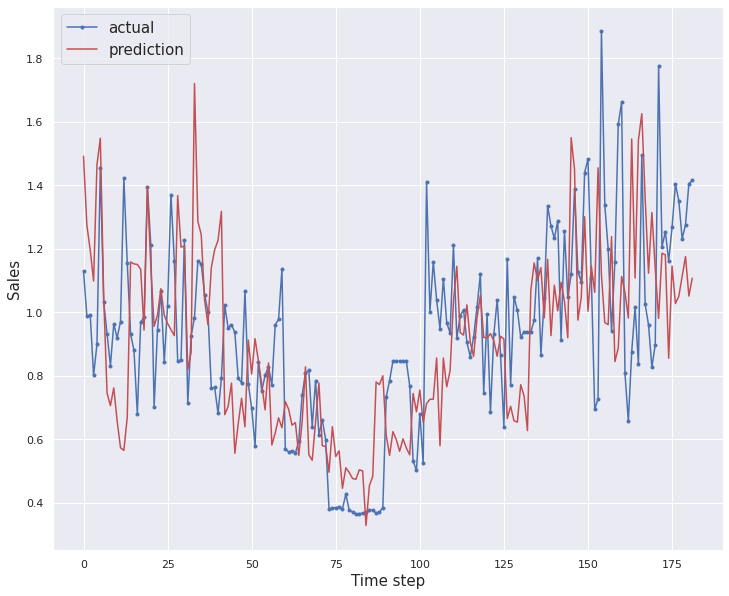

Time Taken for current trial is: 00:06:36
****************************************************************************************************


In [88]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="TCN", n_in=9)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

## MACNN

### Window-1

In [89]:
prediction_window = 1#
reframed = series_to_supervised(dat[["Global_active_power"]], 28, n_out=prediction_window)
reframed = pd.merge(dat[["maxtempC","mintempC"]], reframed, left_index=True, right_index=True)
#print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
#print(reframed.head())

Shape of scaled dataset- (1412, 31)
Shape of reframed dataset- (1412, 31)


In [90]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


175

In [91]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1225
182
(1225, 30) (1225, 1) (182, 30) (182, 1)


In [92]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1225, 30, 1)
Validation set shape (182, 30, 1)


#### WOReg

Train dataset shape- (1225, 30, 1)
Test dataset shape- (182, 30, 1)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-100
Learning rate used in model-0.00400
Error metric used in model-mae
Compiling MACNN model Architecture(without regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 30, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 30, 64)       512         series[0][0]                     
_________________

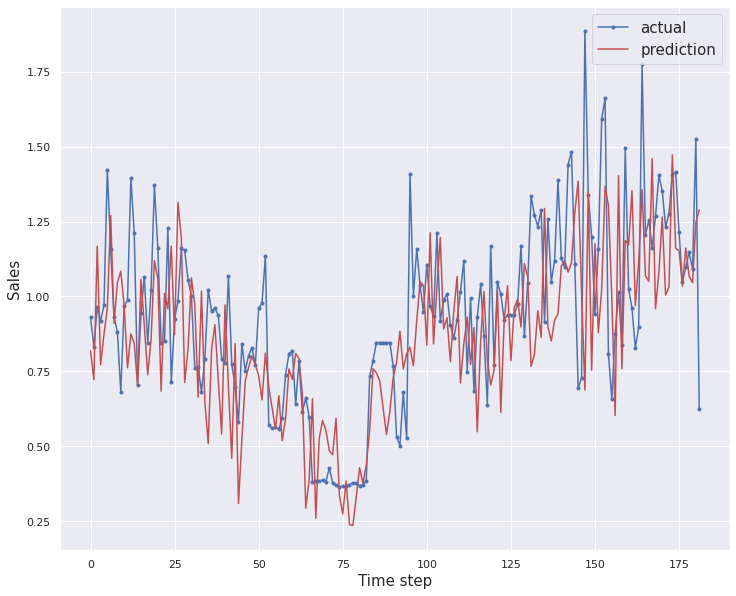

Time Taken for current trial is: 00:06:24
****************************************************************************************************


In [93]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="MACNN", n_in=30, l2_regularizer=False)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

#### With Reg

Train dataset shape- (1225, 30, 1)
Test dataset shape- (182, 30, 1)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-100
Learning rate used in model-0.00400
Error metric used in model-mae
Compiling MACNN model Architecture(with regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 30, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 30, 64)       512         series[0][0]                     
____________________

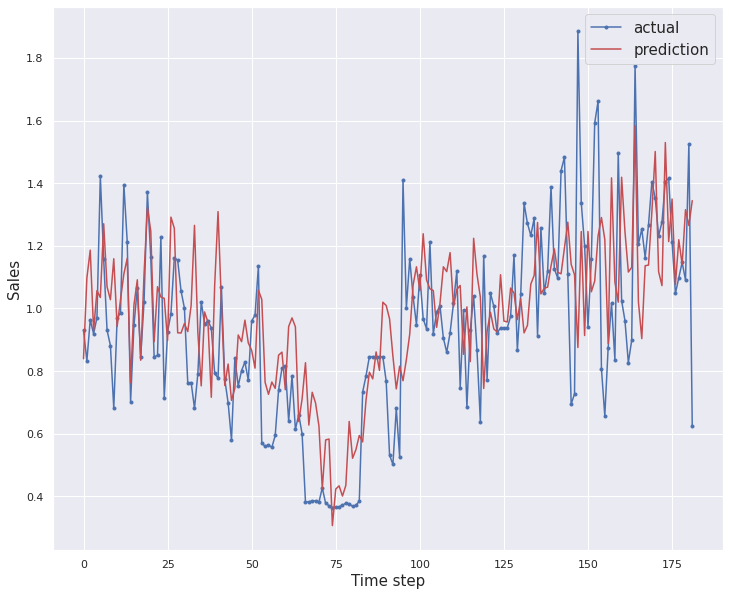

Time Taken for current trial is: 00:05:33
****************************************************************************************************


In [95]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="MACNN", n_in=30, l2_regularizer=True)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

### Window-7

In [96]:
prediction_window = 7#
reframed = series_to_supervised(dat[["Global_active_power"]], 28, n_out=prediction_window)
reframed = pd.merge(dat[["maxtempC","mintempC"]], reframed, left_index=True, right_index=True)
#print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
#print(reframed.head())

Shape of scaled dataset- (1406, 37)
Shape of reframed dataset- (1406, 37)


In [97]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


174

In [98]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1218
182
(1218, 30) (1218, 7) (182, 30) (182, 7)


In [99]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1218, 30, 1)
Validation set shape (182, 30, 1)


#### WO Reg

Train dataset shape- (1218, 30, 1)
Test dataset shape- (182, 30, 1)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-100
Learning rate used in model-0.00400
Error metric used in model-mae
Compiling MACNN model Architecture(without regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 30, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 30, 64)       512         series[0][0]                     
_________________

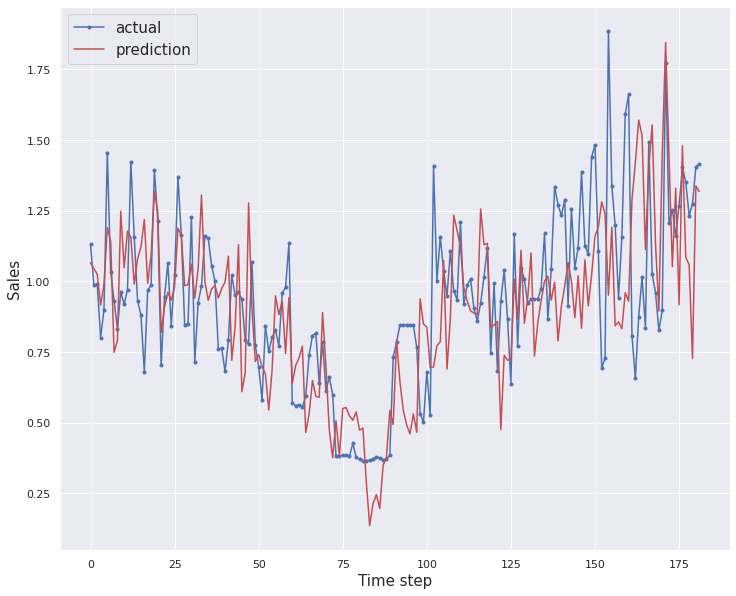

Time Taken for current trial is: 00:06:29
****************************************************************************************************


In [100]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="MACNN", n_in=30, l2_regularizer=False)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

#### With Reg

Train dataset shape- (1218, 30, 1)
Test dataset shape- (182, 30, 1)
********** Trial-1 **********
Number of repeats tried-5
Epochs used in model-100
Learning rate used in model-0.00400
Error metric used in model-mae
Compiling MACNN model Architecture(with regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 30, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 30, 64)       512         series[0][0]                     
____________________

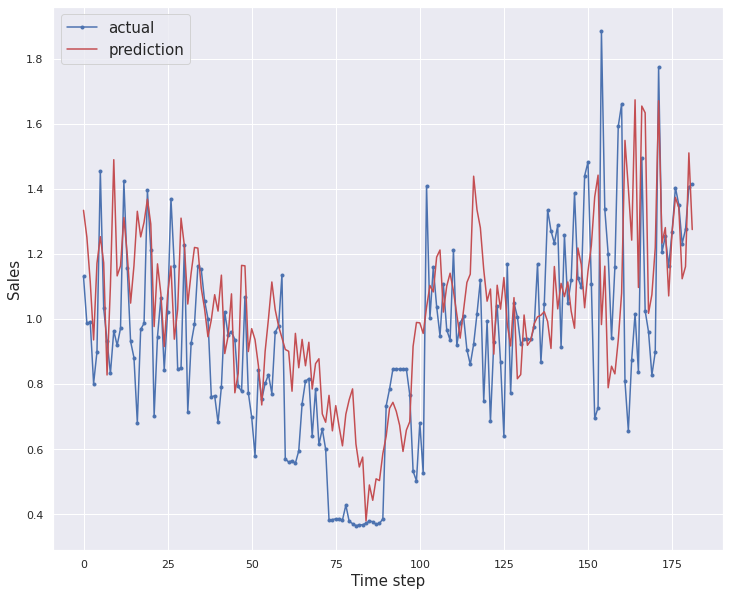

Time Taken for current trial is: 00:06:33
****************************************************************************************************


In [102]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="MACNN", n_in=30, l2_regularizer=True)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)